# Install all necessary packages

In [1]:
#!pip install pandas Pillow opencv-python matplotlib

# Import all necessary libraries

In [2]:
import os
import pandas as pd

# Read in colors datafile

In [3]:
colors = pd.read_csv('colors.csv')
colors

,color,code,R,G,B
0,Air Force Blue (Raf),#5d8aa8,93,138,168
1,Air Force Blue (Usaf),#00308f,0,48,143
2,Air Superiority Blue,#72a0c1,114,160,193
3,Alabama Crimson,#a32638,163,38,56
4,Alice Blue,#f0f8ff,240,248,255
...,...,...,...,...,...
860,Yellow Orange,#ffae42,255,174,66
861,Yellow (Process),#ffef00,255,239,0
862,Yellow (Ryb),#fefe33,254,254,51
863,Zaffre,#0014a8,0,20,168


# Define image path

In [4]:
#image_path = 'images/flower.jpeg'
#image_path = 'images/monroe.jpeg'
#image_path = 'images/ombre.jpeg'
#image_path = 'images/vermeer.jpeg'
image_path = 'images/warhol.jpeg'

# Display image

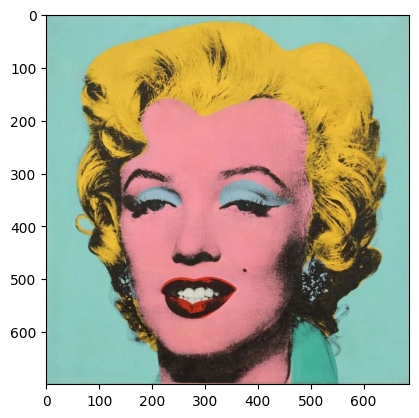

In [5]:
import cv2
import matplotlib.pyplot as plt

# Plot...
original_image = cv2.imread(image_path)
original_image = original_image[:, :, ::-1]
plt.imshow(original_image)

# Simply running this built in method did not work too well for me...

In [6]:
from PIL import Image
img = Image.open(image_path)
detected_colors = img.convert('RGB').getcolors(maxcolors=256)
detected_colors

# My Solution...

In [7]:
def resize_image(width, height, threshold):
    """
    Function takes in an image's original dimensions and returns the 
    new width and height while maintaining its aspect ratio where 
    both are below the threshold. Purpose is to reduce runtime and 
    not distort the original image too much. 
    
    Parameters
    ----------
    width : int
        original width of image
    height : int 
        original height of image
    threshold : int
        max dimension size for both width and height
    """
    if (width > threshold) or (height > threshold):
        max_dim = max(width, height)
        if height == max_dim:
            new_width = int((width * threshold) / height)
            new_height = threshold
        if width == max_dim:
            new_height = int((height * threshold) / width)
            new_width = threshold
        return new_height, new_width
    else: return height, width

In [8]:
def detect_colors(image_path):
    """
    Function returns colors detected in image. 
    
    Parameters
    ----------
    image_path : str
        path to imagefile for detection
        
    Return
    ------
    sorted list of tuples (color, total number detections) 
    """
    
    # Read image
    image = Image.open(image_path)
    
    # Convert image into RGB
    image = image.convert('RGB')

    # Get width and height of image
    width, height = image.size
    print(f'Original dimensions: {width} x {height}')
    
    # Resize image to improve runtime
    width, height = resize_image(width, height, threshold=100)
    print(f'New dimensions: {width} x {height}')
    image = image.resize((width, height))
 
    # Iterate through each pixel
    detected_colors = {} # hash-map
    for x in range(0, width):
        for y in range(0, height):
            # r,g,b value of pixel
            r, g, b = image.getpixel((x, y))
            rgb = f'{r}:{g}:{b}'
            if rgb in detected_colors:
                detected_colors[rgb] += 1
            else: 
                detected_colors[rgb] = 1
 
    # Sort colors from most common to least common
    detected_colors = sorted(detected_colors.items(), key=lambda x:x[1], reverse=True)

    return detected_colors

In [9]:
detected_colors = detect_colors(image_path)
detected_colors

Original dimensions: 687 x 699
New dimensions: 100 x 98


[('140:203:193', 85),
 ('139:202:192', 81),
 ('137:201:189', 46),
 ('142:203:194', 42),
 ('140:203:191', 42),
 ('140:203:192', 41),
 ('139:202:190', 37),
 ('141:202:193', 33),
 ('141:204:194', 32),
 ('144:204:197', 30),
 ('140:201:192', 28),
 ('146:206:200', 27),
 ('142:203:196', 26),
 ('142:203:195', 24),
 ('138:201:189', 24),
 ('141:204:193', 22),
 ('138:201:191', 22),
 ('145:205:198', 22),
 ('147:203:191', 21),
 ('142:204:192', 20),
 ('230:187:60', 19),
 ('139:202:191', 18),
 ('144:204:196', 18),
 ('138:201:192', 18),
 ('143:204:196', 17),
 ('140:201:190', 17),
 ('140:202:191', 16),
 ('141:204:192', 16),
 ('143:203:196', 15),
 ('139:200:191', 15),
 ('145:205:197', 15),
 ('145:204:191', 14),
 ('141:202:191', 14),
 ('140:202:193', 14),
 ('137:200:190', 14),
 ('144:204:195', 14),
 ('229:186:59', 14),
 ('146:202:190', 14),
 ('143:204:197', 13),
 ('136:200:187', 13),
 ('137:200:191', 13),
 ('146:206:199', 13),
 ('146:205:196', 12),
 ('142:203:192', 12),
 ('141:203:194', 12),
 ('142:203:1

In [10]:
def get_color_codes(detected_colors):
    """ 
    Function finds the best matches between detected color codes and source color 
    codes from: https://www.colorhexa.com 

    Parameters
    ---------
    detected_colors : list
        list of detected colors in image
    color_codes : list
        list of best matches
    """
    
    color_codes = []
    for idx,detected_color in enumerate(detected_colors):
        detected_color = detected_color[0].split(':')
        print(f'Processing {detected_color}...{idx+1}/{len(detected_colors)}')
        
        # Calculate absolute differences
        color_map = []
        for idx,row in colors.iterrows():
            r = abs(int(detected_color[0]) - row['R'])
            g = abs(int(detected_color[1]) - row['G'])
            b = abs(int(detected_color[2]) - row['B'])
    
            # Query row values
            color = row['color'], 
            code = row['code'].replace('#', '')
    
            # Map results
            color_map.append({'color':color, 'code':code, 'distance':sum([r,g,b])})
        
        # Get best match (shortest distance)
        best_match = min(color_map, key=lambda x:x['distance'])
        
        # Get color code
        color_code = best_match['code']
        if color_code not in color_codes: color_codes.append(color_code)
    
    return color_codes

In [11]:
# I've noticed that not every consecutive pixel is a different color (only slight variations) 
# So I recommend splicing up detected_colors to improve run time
color_codes = get_color_codes(detected_colors[0::10])
color_codes

Processing ['140', '203', '193']...1/617
Processing ['140', '201', '192']...2/617
Processing ['230', '187', '60']...3/617
Processing ['145', '205', '197']...4/617
Processing ['137', '200', '191']...5/617
Processing ['139', '200', '189']...6/617
Processing ['141', '204', '196']...7/617
Processing ['141', '202', '192']...8/617
Processing ['244', '149', '156']...9/617
Processing ['139', '201', '192']...10/617
Processing ['147', '206', '200']...11/617
Processing ['144', '203', '190']...12/617
Processing ['239', '146', '154']...13/617
Processing ['237', '145', '151']...14/617
Processing ['136', '199', '190']...15/617
Processing ['225', '182', '56']...16/617
Processing ['241', '149', '155']...17/617
Processing ['241', '148', '158']...18/617
Processing ['144', '205', '194']...19/617
Processing ['136', '200', '186']...20/617
Processing ['137', '200', '187']...21/617
Processing ['42', '38', '33']...22/617
Processing ['243', '152', '160']...23/617
Processing ['148', '205', '198']...24/617
Proces

Processing ['98', '80', '43']...203/617
Processing ['234', '189', '63']...204/617
Processing ['123', '99', '47']...205/617
Processing ['175', '113', '119']...206/617
Processing ['214', '134', '142']...207/617
Processing ['73', '85', '79']...208/617
Processing ['131', '188', '178']...209/617
Processing ['224', '181', '51']...210/617
Processing ['216', '140', '151']...211/617
Processing ['46', '40', '34']...212/617
Processing ['156', '102', '102']...213/617
Processing ['80', '72', '41']...214/617
Processing ['125', '185', '176']...215/617
Processing ['214', '170', '54']...216/617
Processing ['214', '173', '50']...217/617
Processing ['126', '85', '86']...218/617
Processing ['55', '45', '39']...219/617
Processing ['195', '122', '128']...220/617
Processing ['60', '48', '28']...221/617
Processing ['139', '203', '200']...222/617
Processing ['102', '82', '43']...223/617
Processing ['216', '177', '50']...224/617
Processing ['69', '50', '44']...225/617
Processing ['43', '38', '30']...226/617
Pro

Processing ['184', '113', '118']...401/617
Processing ['213', '127', '133']...402/617
Processing ['238', '150', '153']...403/617
Processing ['127', '149', '157']...404/617
Processing ['216', '128', '135']...405/617
Processing ['187', '115', '119']...406/617
Processing ['221', '133', '139']...407/617
Processing ['213', '172', '54']...408/617
Processing ['195', '122', '127']...409/617
Processing ['230', '150', '154']...410/617
Processing ['219', '134', '142']...411/617
Processing ['66', '47', '45']...412/617
Processing ['144', '206', '198']...413/617
Processing ['133', '86', '87']...414/617
Processing ['222', '144', '150']...415/617
Processing ['198', '121', '127']...416/617
Processing ['48', '38', '37']...417/617
Processing ['145', '207', '199']...418/617
Processing ['146', '116', '45']...419/617
Processing ['226', '140', '149']...420/617
Processing ['222', '141', '148']...421/617
Processing ['183', '111', '115']...422/617
Processing ['65', '45', '41']...423/617
Processing ['227', '136'

Processing ['148', '205', '191']...598/617
Processing ['117', '103', '55']...599/617
Processing ['152', '130', '62']...600/617
Processing ['87', '71', '42']...601/617
Processing ['133', '163', '146']...602/617
Processing ['114', '157', '142']...603/617
Processing ['106', '120', '93']...604/617
Processing ['134', '105', '44']...605/617
Processing ['174', '160', '87']...606/617
Processing ['76', '76', '48']...607/617
Processing ['137', '185', '172']...608/617
Processing ['96', '127', '117']...609/617
Processing ['135', '192', '186']...610/617
Processing ['138', '183', '171']...611/617
Processing ['145', '203', '200']...612/617
Processing ['145', '205', '193']...613/617
Processing ['140', '200', '194']...614/617
Processing ['156', '202', '194']...615/617
Processing ['138', '200', '196']...616/617
Processing ['146', '200', '189']...617/617


['88d8c0',
 'e5b73b',
 'ff9999',
 '96ded1',
 'ef98aa',
 'e18e96',
 '1a2421',
 'a0d6b4',
 'd4af37',
 'd7837f',
 'b78727',
 '3d2b1f',
 'cba135',
 'c08081',
 'b57281',
 '3eb489',
 '43b3ae',
 '9ab973',
 '87a96b',
 'bdb76b',
 '96c8a2',
 '8fbc8f',
 '6c541e',
 'c5b358',
 '4b5320',
 'b5a642',
 '6f4e37',
 '967117',
 '483c32',
 '826644',
 '654321',
 '4b3621',
 '778899',
 '414a4c',
 '3c341f',
 '91a3b0',
 '5f9ea0',
 '635147',
 'b76e79',
 '4d5d53',
 '996666',
 '836953',
 'b87333',
 'deaa88',
 '99badd',
 'f78fa7',
 '343434',
 '66424d',
 '8b8589',
 'cc8899',
 '893f45',
 '701c1c',
 '645452',
 '321414',
 '674846',
 'e4717a',
 'e3a857',
 'c9c0bb',
 '696969',
 'af4035',
 '722f37',
 '7c4848',
 'b31b1b',
 'e66771',
 '3c1414',
 'e5aa70',
 'a9a9a9',
 '704241',
 'cfb53b',
 'b94e48',
 'b39eb5',
 'e1a95f',
 'dea5a4',
 'a2add0',
 'aec6cf',
 '8c92ac',
 '905d5d',
 'ad6f69',
 '6e7f80',
 'e9967a',
 '50404d',
 '3b444b',
 'a57164',
 'cd853f',
 '555d50',
 '40826d',
 '49796b',
 'f4c430',
 '3b3c36',
 '534b4f',
 '2f847c',

In [12]:
print(f'Total unique colors found in image: {len(color_codes)}')

Total unique colors found in image: 96


# Display main color and color tones in image

## Reminder: The first color is the dominant color in image!

Closest color match: Pearl Aqua (#88d8c0)


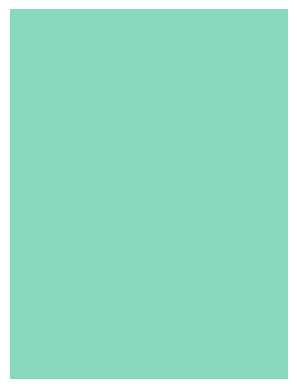

Closest color match: Meat Brown (#e5b73b)


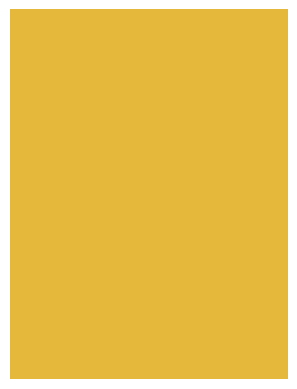

Closest color match: Light Salmon Pink (#ff9999)


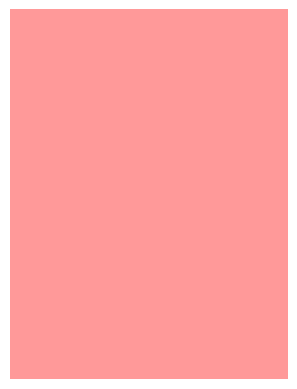

Closest color match: Pale Robin Egg Blue (#96ded1)


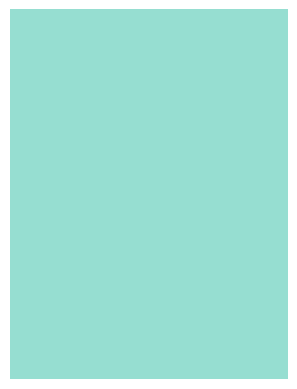

Closest color match: Mauvelous (#ef98aa)


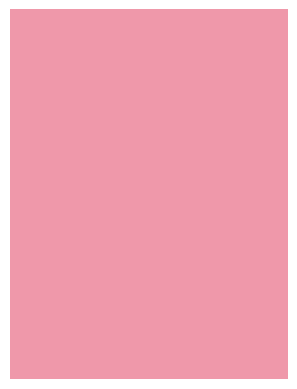

Closest color match: Ruddy Pink (#e18e96)


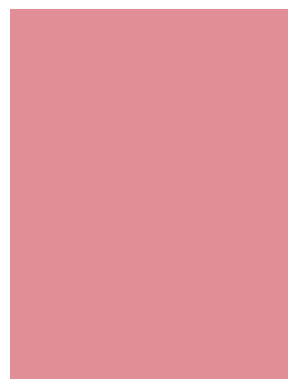

Closest color match: Dark Jungle Green (#1a2421)


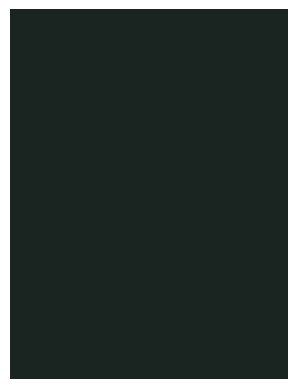

Closest color match: Turquoise Green (#a0d6b4)


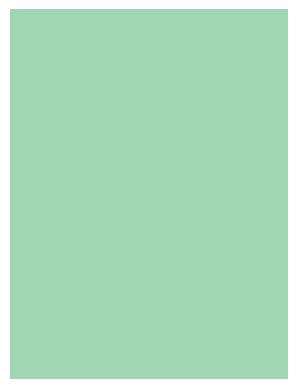

Closest color match: Gold (Metallic) (#d4af37)


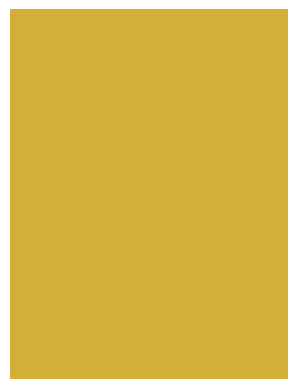

Closest color match: New York Pink (#d7837f)


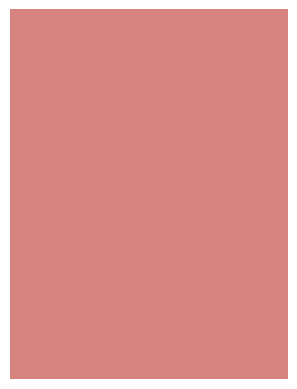

Closest color match: University Of California Gold (#b78727)


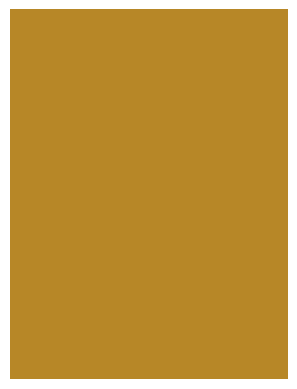

Closest color match: Bistre (#3d2b1f)


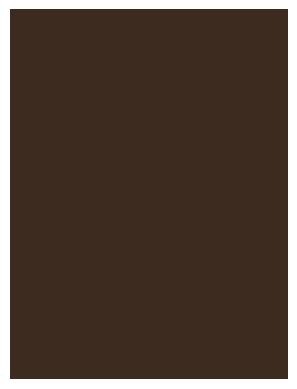

Closest color match: Satin Sheen Gold (#cba135)


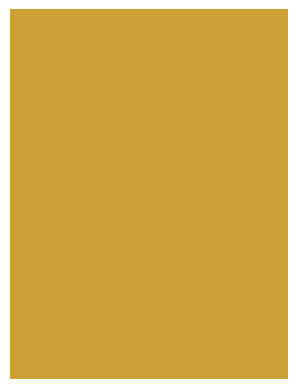

Closest color match: Old Rose (#c08081)


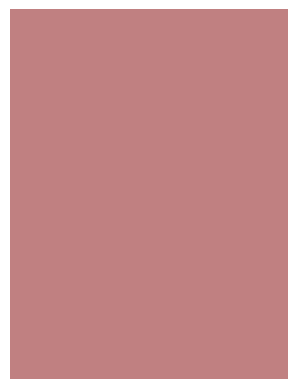

Closest color match: Turkish Rose (#b57281)


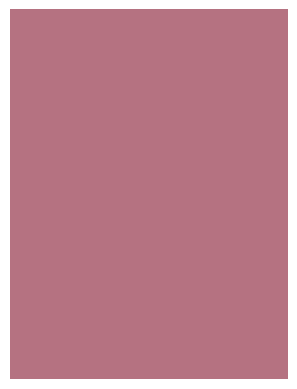

Closest color match: Mint (#3eb489)


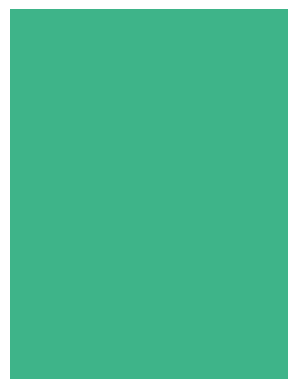

Closest color match: Verdigris (#43b3ae)


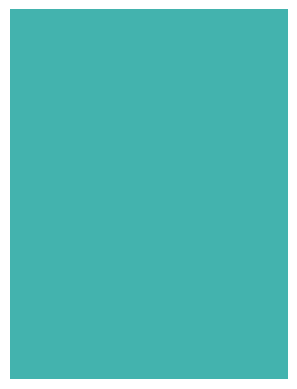

Closest color match: Olivine (#9ab973)


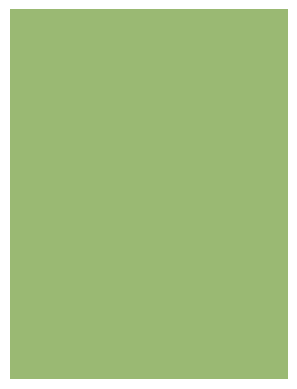

Closest color match: Asparagus (#87a96b)


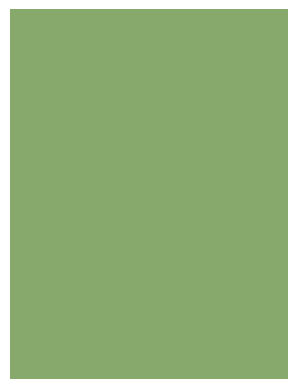

Closest color match: Dark Khaki (#bdb76b)


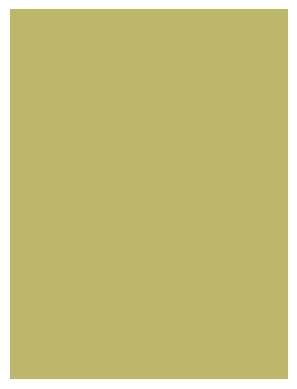

Closest color match: Eton Blue (#96c8a2)


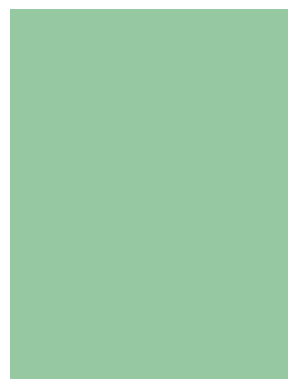

Closest color match: Dark Sea Green (#8fbc8f)


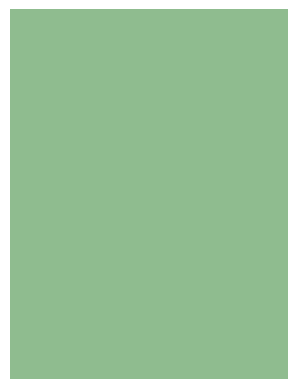

Closest color match: Field Drab (#6c541e)


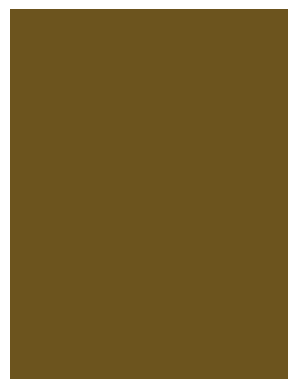

Closest color match: Vegas Gold (#c5b358)


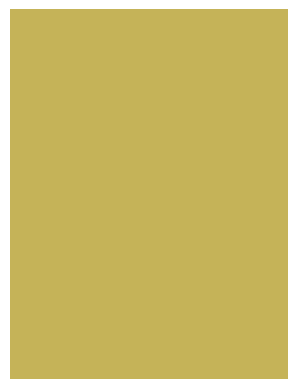

Closest color match: Army Green (#4b5320)


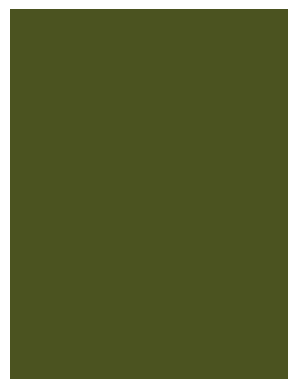

Closest color match: Brass (#b5a642)


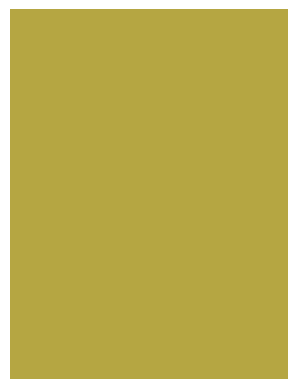

Closest color match: Coffee (#6f4e37)


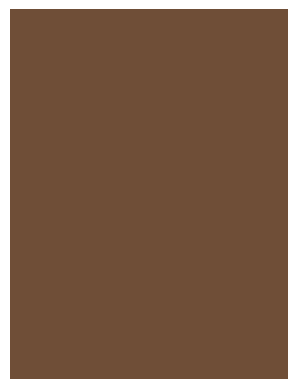

Closest color match: Drab (#967117)


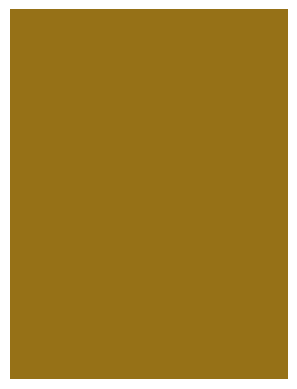

Closest color match: Dark Lava (#483c32)


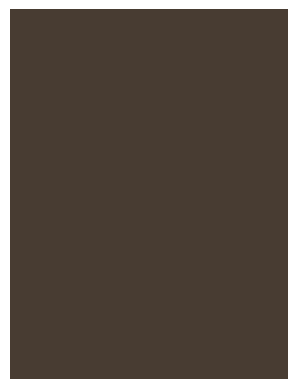

Closest color match: Raw Umber (#826644)


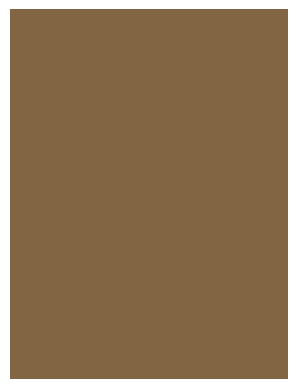

Closest color match: Dark Brown (#654321)


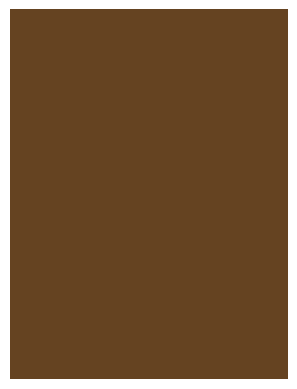

Closest color match: Café Noir (#4b3621)


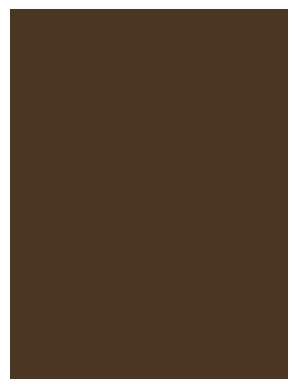

Closest color match: Light Slate Gray (#778899)


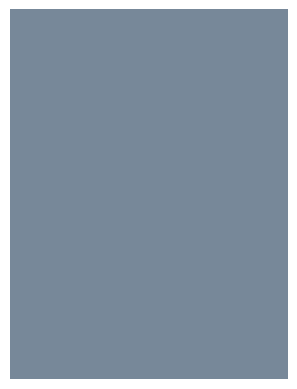

Closest color match: Outer Space (#414a4c)


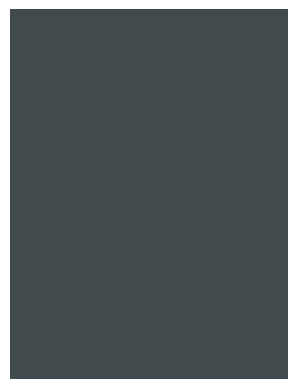

Closest color match: Olive Drab #7 (#3c341f)


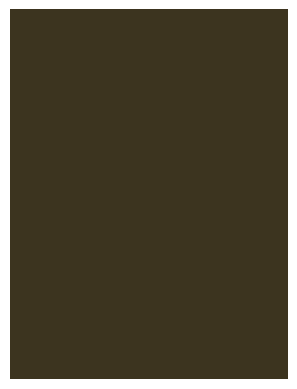

Closest color match: Cadet Grey (#91a3b0)


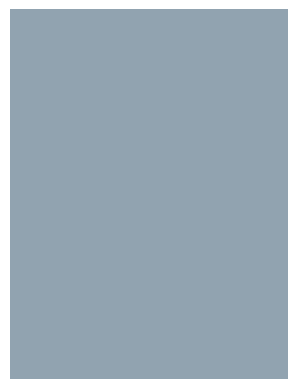

Closest color match: Cadet Blue (#5f9ea0)


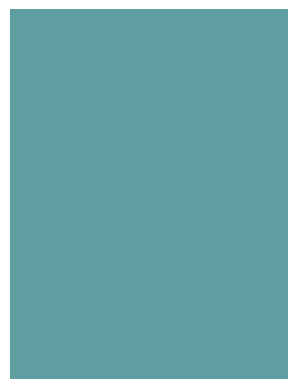

Closest color match: Umber (#635147)


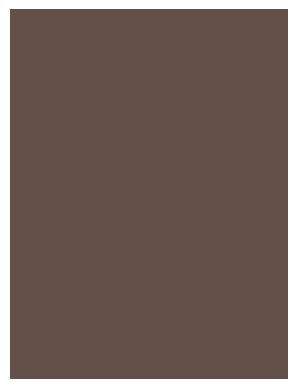

Closest color match: Rose Gold (#b76e79)


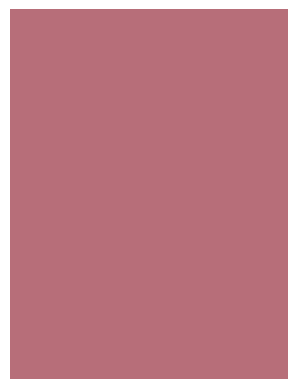

Closest color match: Feldgrau (#4d5d53)


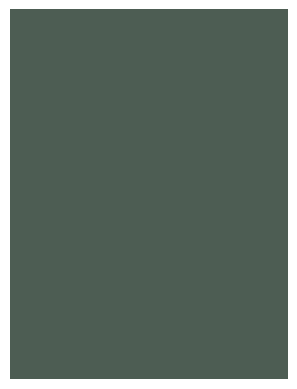

Closest color match: Copper Rose (#996666)


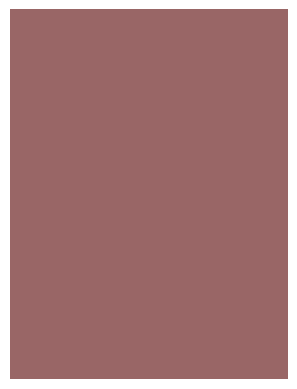

Closest color match: Pastel Brown (#836953)


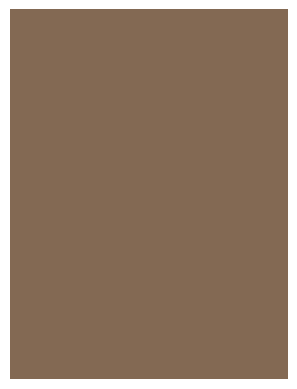

Closest color match: Copper (#b87333)


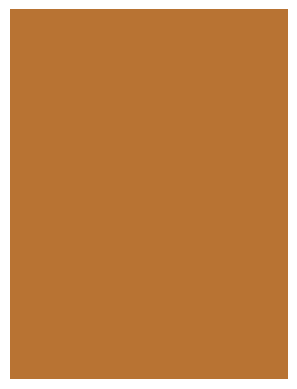

Closest color match: Tumbleweed (#deaa88)


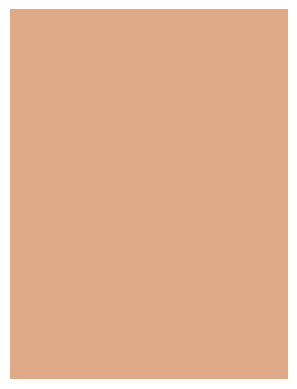

Closest color match: Carolina Blue (#99badd)


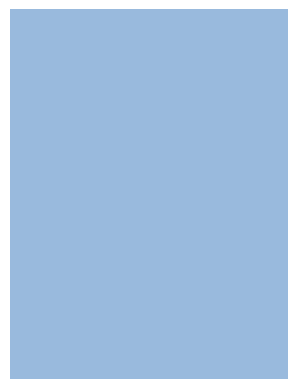

Closest color match: Pink Sherbet (#f78fa7)


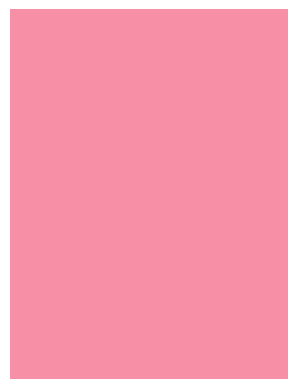

Closest color match: Jet (#343434)


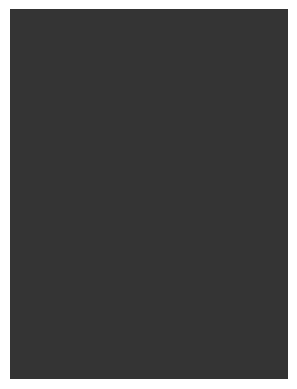

Closest color match: Deep Tuscan Red (#66424d)


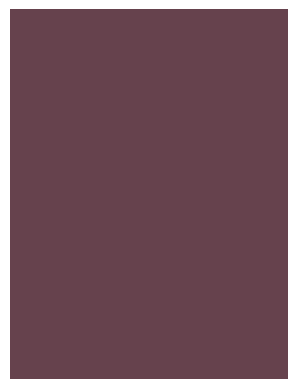

Closest color match: Taupe Gray (#8b8589)


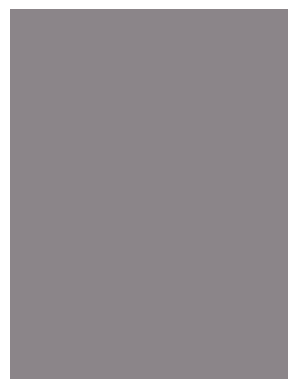

Closest color match: Puce (#cc8899)


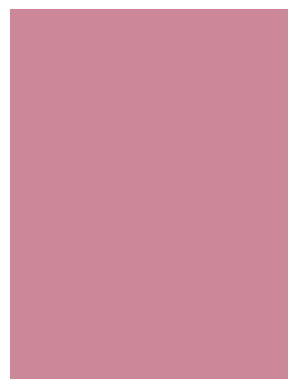

Closest color match: Cordovan (#893f45)


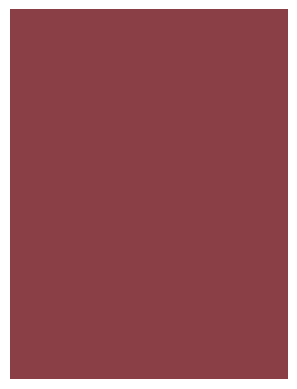

Closest color match: Persian Plum (#701c1c)


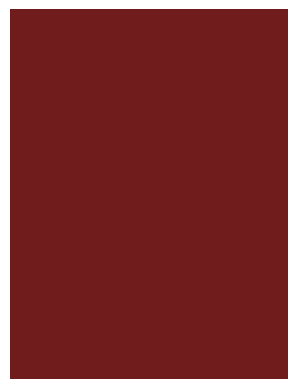

Closest color match: Wenge (#645452)


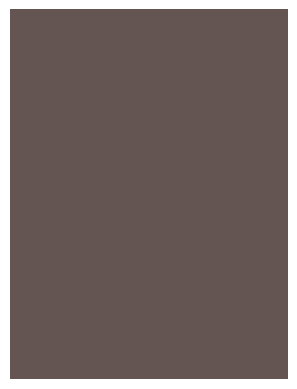

Closest color match: Seal Brown (#321414)


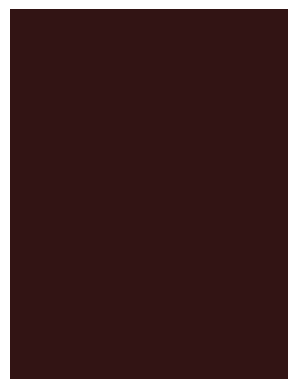

Closest color match: Rose Ebony (#674846)


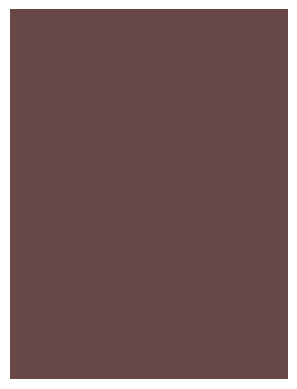

Closest color match: Candy Pink (#e4717a)


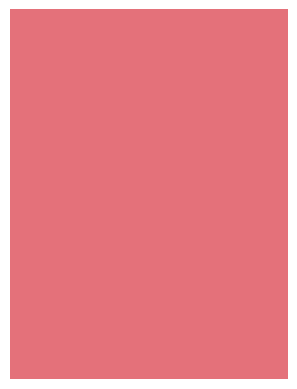

Closest color match: Indian Yellow (#e3a857)


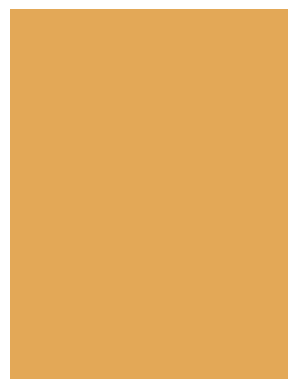

Closest color match: Pale Silver (#c9c0bb)


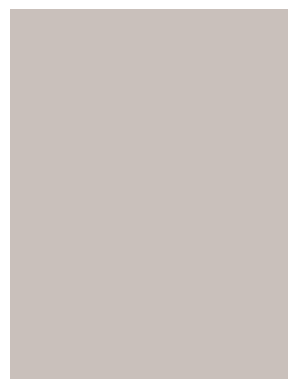

Closest color match: Dim Gray (#696969)


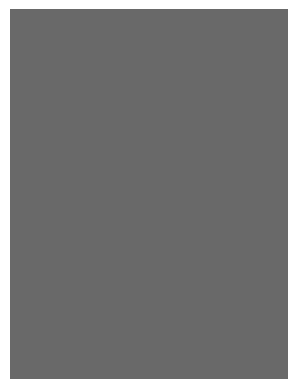

Closest color match: Medium Carmine (#af4035)


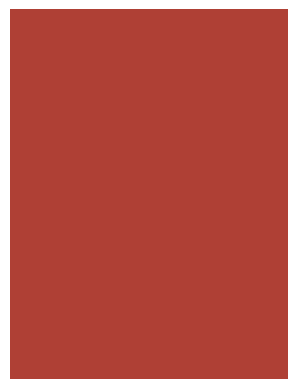

Closest color match: Wine (#722f37)


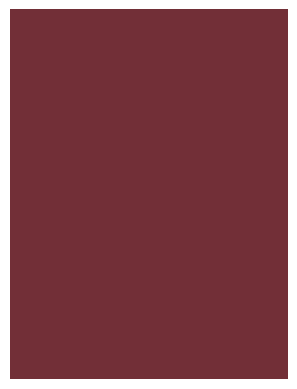

Closest color match: Tuscan Red (#7c4848)


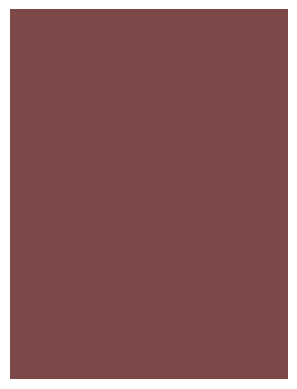

Closest color match: Carnelian (#b31b1b)


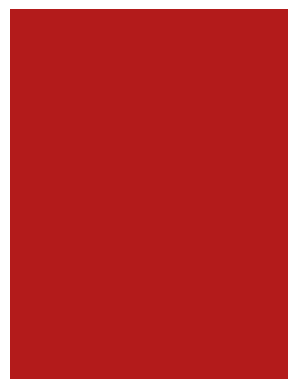

Closest color match: Light Carmine Pink (#e66771)


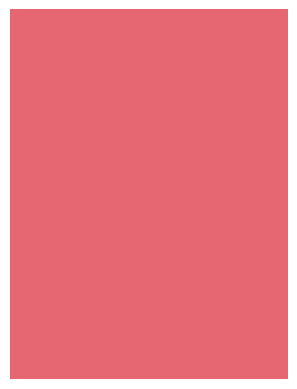

Closest color match: Dark Sienna (#3c1414)


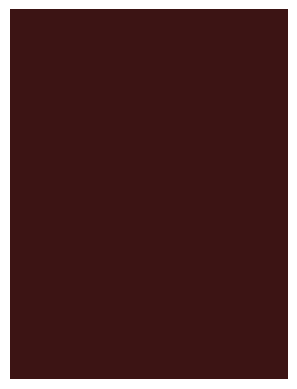

Closest color match: Fawn (#e5aa70)


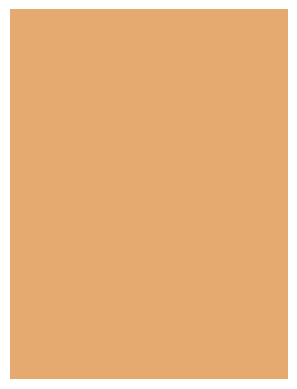

Closest color match: Dark Gray (#a9a9a9)


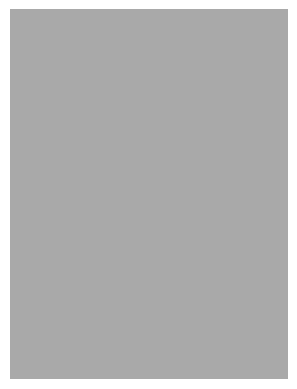

Closest color match: Deep Coffee (#704241)


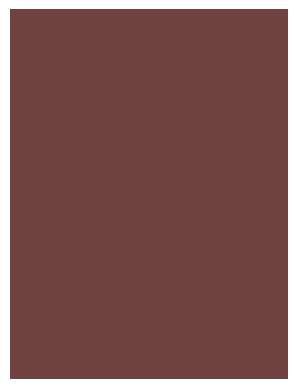

Closest color match: Old Gold (#cfb53b)


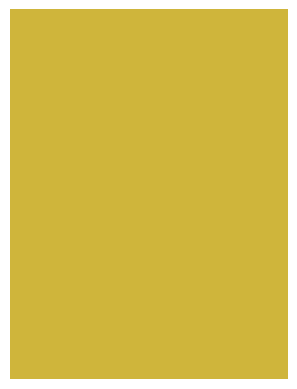

Closest color match: Deep Chestnut (#b94e48)


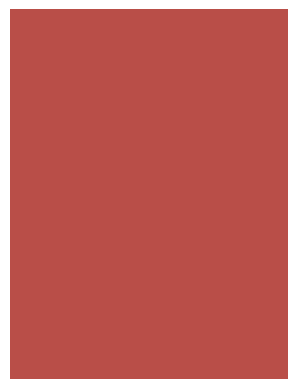

Closest color match: Pastel Purple (#b39eb5)


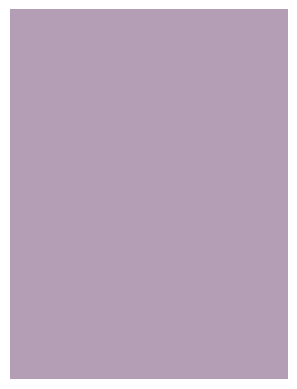

Closest color match: Earth Yellow (#e1a95f)


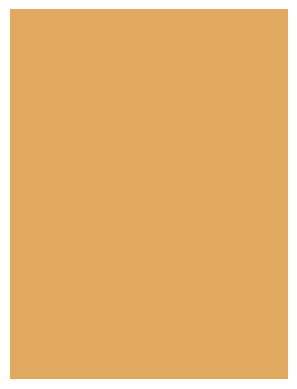

Closest color match: Pastel Pink (#dea5a4)


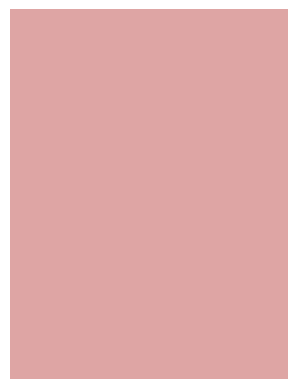

Closest color match: Wild Blue Yonder (#a2add0)


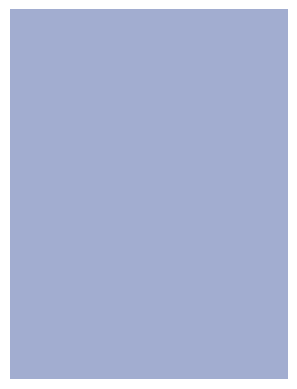

Closest color match: Pastel Blue (#aec6cf)


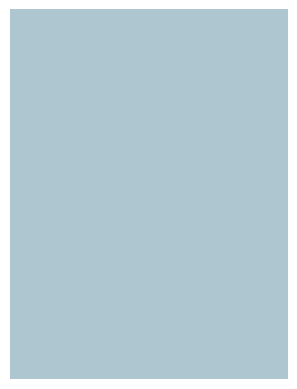

Closest color match: Cool Grey (#8c92ac)


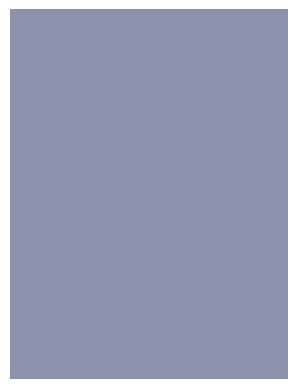

Closest color match: Rose Taupe (#905d5d)


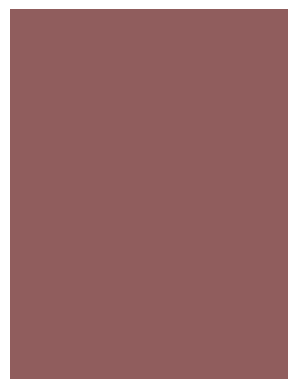

Closest color match: Copper Penny (#ad6f69)


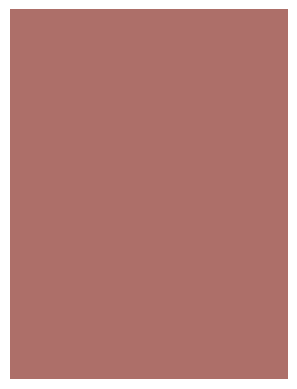

Closest color match: Aurometalsaurus (#6e7f80)


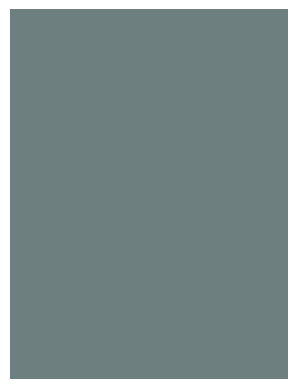

Closest color match: Dark Salmon (#e9967a)


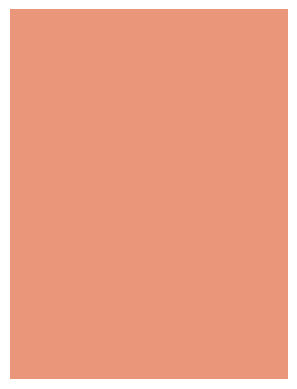

Closest color match: Purple Taupe (#50404d)


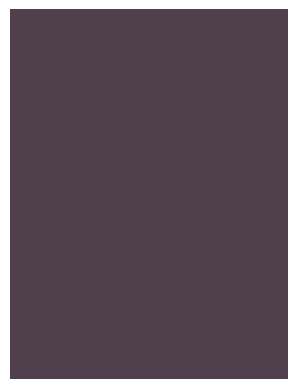

Closest color match: Arsenic (#3b444b)


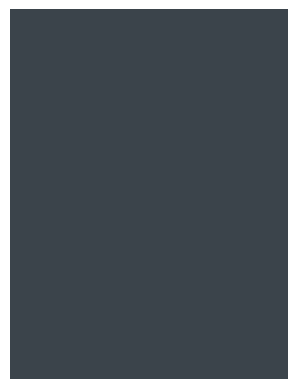

Closest color match: Blast-Off Bronze (#a57164)


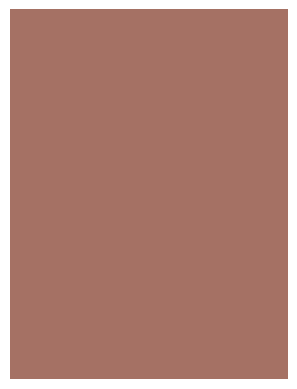

Closest color match: Peru (#cd853f)


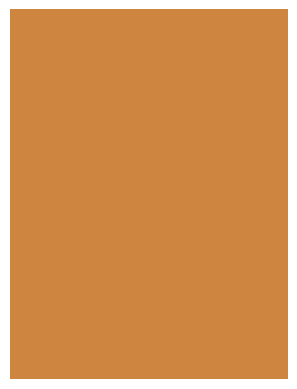

Closest color match: Ebony (#555d50)


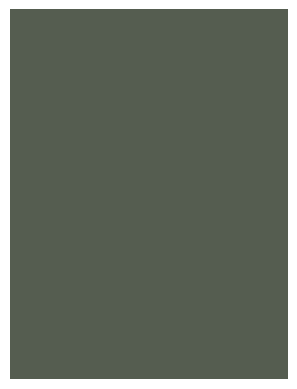

Closest color match: Viridian (#40826d)


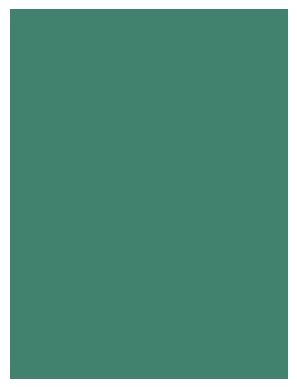

Closest color match: Hooker'S Green (#49796b)


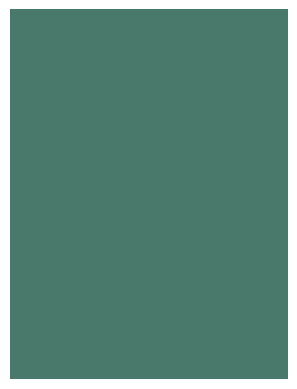

Closest color match: Saffron (#f4c430)


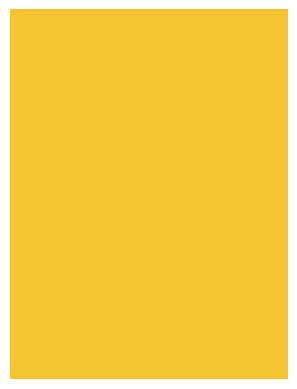

Closest color match: Black Olive (#3b3c36)


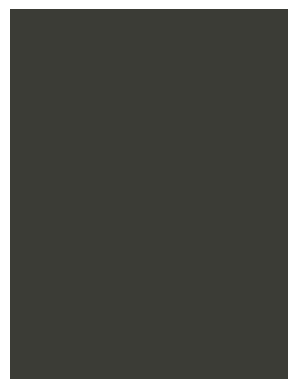

Closest color match: Liver (#534b4f)


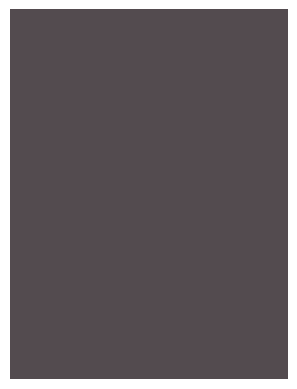

Closest color match: Celadon Green (#2f847c)


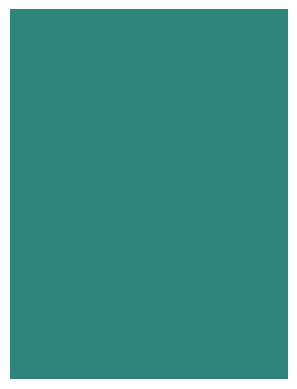

Closest color match: Moonstone Blue (#73a9c2)


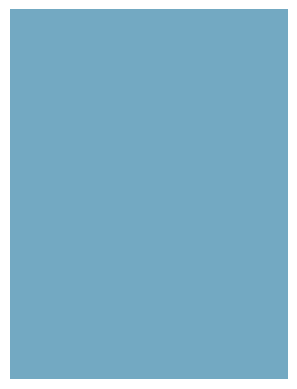

Closest color match: Chamoisee (#a0785a)


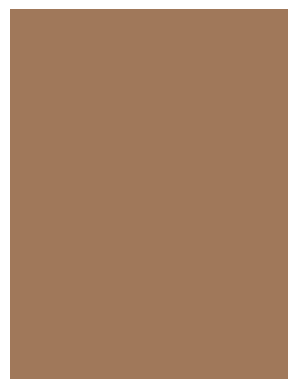

Closest color match: Dark Tan (#918151)


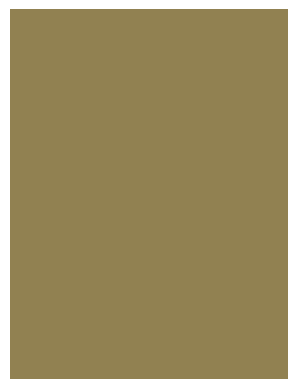

Closest color match: Slate Gray (#708090)


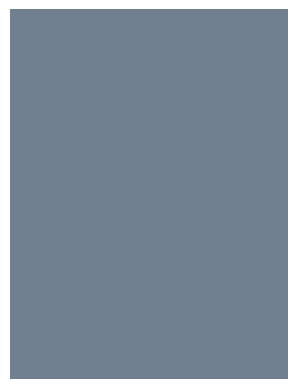

Closest color match: Rifle Green (#414833)


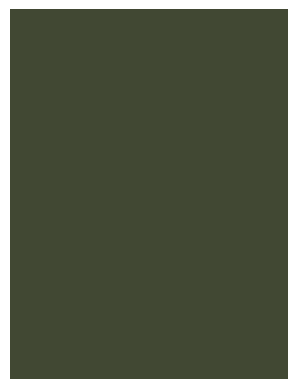

In [13]:
import matplotlib.image as mpimg
for color_code in color_codes:
    # Define color path
    colorfile = os.path.join('colors', color_code + '.png')
    # Query color name associated with color code
    color_name = colors[colors['code'] == f'#{color_code}']['color'].values[0]
    # Read in imagefile
    img = mpimg.imread(colorfile)
    # Plot color match
    imgplot = plt.imshow(img)
    plt.axis('off')
    print(f'Closest color match: {color_name} (#{color_code})')
    plt.show()